# Oscillating Van der Pol Systems

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $\mu$, $A$ and $\omega$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, $A=1$ and $\omega=1$ fixed.

In [4]:
# Select ODE & settings:

ode_name = 'OscilVdpODE' # help="name of the ode", type=str
ode_param = None # '1.,1.,1.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10
alg = 'tv'

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [ ]:
# # generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# SINDy_data.plot_configuration(X_list, T)

In [ ]:
# additional building blocks -> running SR-T:
# building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)

building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

NOTE: Building block sin(X1**2) trovato (!)

NOTE: Due equazioni: combinare i building blocks (anche se uno è nullo)

NOTE: Bisogna filtrare i building blocks perche i numeri negativi elevati alla potenza frazionaria sono numeri complessi -> NaN -> error!

NOTE: SINDy degree 3 in questo caso perche nel reale sistema ce un termine cubico: unico modo per trovare il modello corretto

In [ ]:
# combine the two blocks:
bbs, fns = bb_combinations(building_blocks_lambda0, building_blocks_lambda1, function_names0, function_names1, ode.init_high, ode.init_low, dim_x, dim_k)

valid_id = [1,3,4,6]

intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=3, include_bias=False)

errors = []
n_features_vec = []
for i in valid_id: # for i in range(len(bbs)):

    # building block library:
    custom_library = ps.CustomLibrary(library_functions=bbs[i], function_names=fns[i])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 10 and lasso_penalty < 10:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # lasso penalty:
        alpha = 0.01 # regularization parameter
        coefficients = model.coefficients()
        lasso_penalty = np.sum(np.abs(coefficients))

        # final evaluation metric:
        error = mse + alpha * lasso_penalty
        print('')
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)

In [ ]:
# Final model:
min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    # idx = idxs[np.argmin(n_features_vec_2)]
    idx = valid_id[idxs[np.argmin(n_features_vec_2)]]
else:
    # idx = idxs[0]
    idx = valid_id[idxs[0]]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=3, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=bbs[idx], function_names=fns[idx])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

# library:
print('')
length = 0
#print('library:')
library_terms = final_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)
    length += 1
print('length:', length)
print('')


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('Symbolic-SINDy model:')
model.print()

In [ ]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.2, 0.8], [0.2, 0.8], dim_x, dim_k, title=title, T_aux=12)

In questo caso il sitema di ODE è stato identificato alla perfezione, giustificando l'impiego di una regressione simbolica per trovare potenziali building blocks rilevanti da mettere in SINDy.

Nota pero che cambiando i parametri, usando quindi parametri diversi da quelli di default, questo approcio fa lo stesso fatica, perché i metodi di Symbolic regression non riescono a beccare la vera dinamica, specialmente cambiando $\omega$ argomento del seno.

#### Case $\mu$, $A$ fixed and $\omega$ varying
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, $A=1$ fixed, and $\omega \in [1,\pi]$.

In [3]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Far variare $\omega$ è l'unica cosa sensata: gli altri termini concettualmente sono gia dentro i blocchi di SINDy perché semplice moltiplicazione tra la parametrizzazione e i block trovati, quindi non dovremmo avere difficoltà con SINDy, una volta identificato il $\sin(x^2)$. Il caso piu challenging è trovare la parametrizzazione sulla pulsazione.

In [4]:
# Select ODE & settings:
ode_name = 'OscilVdpODE_par_w' # help="name of the ode", type=str
ode_param = '1,1' # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10
alg = 'tv'

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 100, 2) (50, 100, 2) (50, 100)
['X0', 'X1', 'X2']


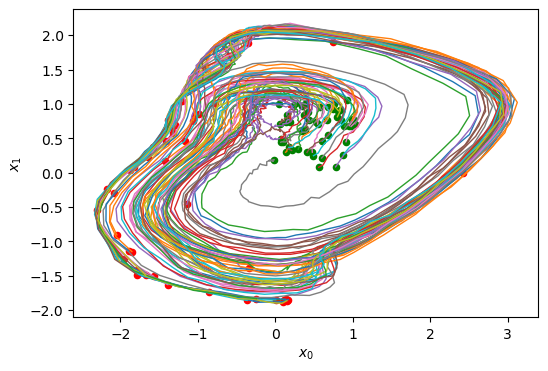

In [5]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

SINDy_data.plot_configuration(X_list, T)

In [6]:
# additional building blocks -> running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE_par_w, ode_param=[1.0, 1.0], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (101, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.24      7.51168e+10        4         0.893103         0.903283      3.45m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.23          1352.44       15         0.869014         0.883714      3.03m
   2     2.56          904.956        4         0.882202          1.00139      2.60m
   3     3.12          20693.9        5         0.865799         0.941484      2.48m
   4     4.30            415.3        6         0.764951         0.792475      2.34m
   5     4.26          257.545        6         0.757598         0.858654      2.48m
   6     4.32            102.6        8         0.724342         0.712651      2.10m
   7     4.56          107.504        8          0.72277           0.7268      2.01m
   8     5.66          2116.79        9         0.706999         0.661046      1.81m
   9     6.06          12335.7        9         0.698302         0.739315      1.61m
  10     6.25          263.952       10         0.616419         0.688002      1.55m
  11     7.04          151.381       10         0.614862         0.702018      1.38m
  12     7.97          115.623       10         0.613056         

In [6]:
# additional building blocks -> running D-CODE:
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE_par_w, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape:  (201, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.24      1.02145e+29        2          204.696          246.311      2.96m
   1     6.94      1.82847e+19        6          165.112          176.644      3.15m
   2     2.90      8.10006e+12        6          164.621          181.061      2.12m
 
promising programs:
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
add(sin(add(X0, X1)), neg(X1))
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
add(sin(add(X0, X1)), neg(X1))
sub(sin(add(X0, X1)), X1)
sub(sin(add(X0, X1)), X1)
m

Commento finale:

La situazione è ben gestita nel primo caso, dove per parametri fissati (con quelli di default) allora in qualche modo il $\sin(x^2)$ salta fuori e aggiungendolo nella libreria di SINDy il modello trovato è quello vero, anche con rumore (es. 5%).

Tuttavia, cambiando i parametri da quelli di default, in particolare $\omega$ quel seno non viene piu beccato, e quindi la vera dinamica non viene mai ricostruita.
Per lo stesso motivo, analizzando la situazione per cui $\omega$ parametrizza la dinamica quel seno non viene visto. Probabilmente la dinamica è complessa vista anche la presenza di diverse combinazioni di X0 e X1, ed entrambi SR-T e D-CODE trovano dei loro building blocks o combinazioni di seni e coseni (che pero non dipendono da X2) oppure improbabili composizioni di seni, coseni e logaritmi. Come detto prima, la dinamica è complessa e la nonlinearità portata da diversi fattori, alla fine viene approssimata con un altro tipo di combinazioni in altre forme, specialmente da D-CODE.

NOTA: In questo caso abbiamo dovuto mettere a SINDy una libreria standard di grado 3, in modo da identificare correttamente la prima parte dell'espressione. Non sempre quel termine viene trovato dalla Symbolic Regression, ma spesso è incorporato insieme a un coseno o altre variabili.

NOTA sul codice gia esistente: Estraiamo solo un building block. Il che è sensato perché non ci aspettiamo che il modello reale sia eccessivamente complesso. In molti casi (questo o Selkov), alzando il degree di SINDy è sufficiente per recuperare la dinamica -> Considera però eventualmente il fatto che a volte potrebbe essere necessario estrarre più building blocks.

#### Case $A$ fixed and $\omega, \mu$ varying
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $A=1$ fixed, and $\omega \in [1,\pi], \mu \in [0.5, 2]$.

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
# Select ODE & settings:
ode_name = 'OscilVdpODE_par_w_mu' # help="name of the ode", type=str
ode_param = '1' # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10
alg = 'tv'

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 2
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 100, 2) (50, 100, 2) (50, 100, 2)
['X0', 'X1']


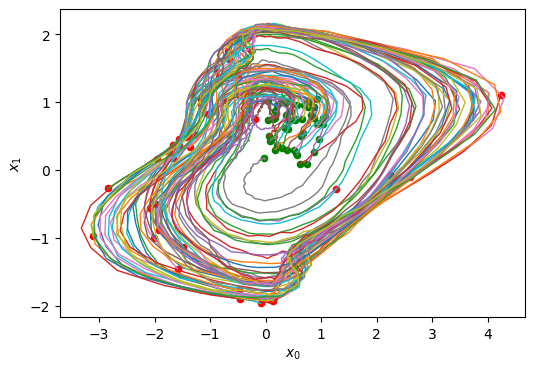

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

SINDy_data.plot_configuration(X_list, T)

In [ ]:
# additional building blocks -> running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)

# lambda 0.01 -> early stopping lontano dalla convergenza
# lambda 0.001 -> discesa rapida ma funzione molto complessa
# lambda 0.005 -> situazione di mezzo

Running with: ode_name=OscilVdpODE_par_w_mu, ode_param=[1.0], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (101, 50, 4)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.75      8.87282e+07        5          1.05922          1.09658      3.27m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.75          282.162        7          1.04159          1.12837      2.79m
   2     3.75          62.4085        8         0.976936          1.09708      2.79m
   3     4.50           73.071        7         0.916634         0.899626      2.78m
   4     5.96          10.9542       12         0.901065         0.997731      2.54m
   5     6.44           43.324       12         0.898774          1.01835      2.69m
   6     8.34          3343.84       20         0.813972         0.896922      2.46m
   7    10.55          20.1695       21         0.817023         0.869468      2.11m
   8     9.72          7060.55       21         0.812116         0.913633      2.11m
   9     8.52          154.984       21         0.808775         0.943702      1.56m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


  10    10.07          129.266       21          0.80542         0.973892      1.67m
  11    13.50          53.3446       21         0.806588          0.96338      1.82m
  12    17.55          26.6784       21         0.801528          1.00892      1.48m
  13    19.61          58.9054       21         0.803812         0.941077      1.51m
  14    19.56           101.44       18         0.798336         0.725594      1.14m
  15    19.38           259.13       18          0.78551          0.84103      1.06m
  16    18.91          29.7091       20         0.762601         0.837581     51.30s
  17    17.99           9981.7       17         0.771391         0.906274      1.01m
  18    16.90          15.0653       23         0.755435         0.788077     21.74s
  19    16.82          51.8189       25         0.740554         0.774684      0.00s

SR-T model:  X0**C*(-X1 + sin(sin(sin(X0 - X1) + sin(C*X1 - sin(sin(sin(X1 - sin(X0))))))))

building blocks:
sin(X0 + X1)
-sin(X1 - sin(X0))
-sin(si

In [5]:
# additional building blocks -> running D-CODE:
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE_par_w_mu, ode_param=[1.0], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape:  (201, 50, 4)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.75      6.29476e+22        2          291.838          559.217      3.26m
   1     6.82       2.0654e+14        2          287.353          599.581      2.90m
   2     3.01      9.52264e+09       12          226.622          322.844      4.81m
 
promising programs:
sub(mul(X3, sin(sin(add(X1, X0)))), X1)
add(neg(X1), sin(add(X3, add(neg(sub(X3, X0)), X1))))
add(neg(X1), sin(add(X3, add(neg(sub(X3, X0)), X1))))
add(neg(X1), sin(add(X3, add(neg(sub(X3, X0)), X1))))
add(neg(X1), sin(add(X3, add(neg(sub(X3

#### Case $\mu$, fixed and $\omega, A$ varying
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, fixed, and $\omega \in [1,\pi], A \in [0,1]$.

In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import Lasso

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from D_CODE.run_simulation import run as run_SRT
from D_CODE.run_simulation_vi import run as run_DCODE

from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
# Select ODE & settings:
ode_name = 'OscilVdpODE_par_w_a' # help="name of the ode", type=str
ode_param = '1' # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10
alg = 'tv'

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 2
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

(50, 100, 2) (50, 100, 2) (50, 100, 2)
['X0', 'X1']


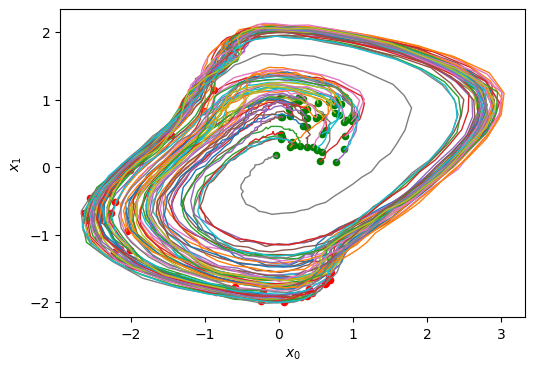

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

SINDy_data.plot_configuration(X_list, T)

In [4]:
# additional building blocks -> running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg='tv', seed=seed, n_seed=n_seed, T=T)

# lambda 0.01 -> early stopping dopo 11 generazioni. errore rimane a 0.80
# lambda 0.001 -> errore che scende fino a 0.40 ma l'equazione è estremamente complessa
# lambda 0.005 -> qua la soluzione è molto sotto controllo con solo 14 termini, ma purtroppo sbagliata erroe 0.5
# lambda 0.008 -> lunghezza 10, errore 0.7 alto ma comunque si tratta della soluzione di prima, meno parsimoniosa

Running with: ode_name=OscilVdpODE_par_w_a, ode_param=[1.0], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (101, 50, 4)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.75      8.94249e+07        5         0.828091         0.833767      3.12m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.40          283.728        6         0.820605         0.901145      2.98m
   2     2.57           73.394        6         0.816415         0.938855      2.56m
   3     3.11          736.868        6         0.815413         0.947872      2.91m
   4     5.17          15.6117       13         0.768189          0.75128      3.01m
   5     5.21          45.3182        8         0.750127         0.753084      2.94m
   6     5.04          3451.02        8         0.746914            0.782      3.21m
   7     5.02          42.3407        8         0.743043         0.816838      2.33m
   8     5.10          39.2284        8         0.740056         0.843726      2.16m
   9     5.30          20.7197        8         0.741532         0.830443      2.00m
  10     5.89          124.066        8         0.736159         0.878802      1.67m
  11     7.20          68.9954        8         0.737155         0.869836      1.51m
  12     7.91          52.3813       10         0.703134         

In [5]:
# additional building blocks -> running D-CODE:
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE_par_w_a, ode_param=[1.0], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape:  (201, 50, 4)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.75      4.83575e+22        2          207.123          245.168      3.36m
   1     6.47      1.12848e+12       10          164.181          229.257      4.29m
   2     2.77      1.06368e+10       10          170.477          172.589      3.38m
 
promising programs:
add(neg(X1), sin(sub(sin(X0), add(X1, X1))))
add(neg(X1), sin(sub(sin(X0), add(X1, X1))))
add(neg(X1), sin(sub(sin(X0), add(X1, X1))))
add(neg(X1), sin(sub(sin(X0), add(X1, X1))))
add(neg(X1), sin(sub(sin(X0), add(X1, X1))))
add(neg(X1), sin(

KeyboardInterrupt: 